# Spam Detection folosind Logistic Regression

In [1]:
!ls

datalab  spam.csv  spam.csv.1  spam.csv.2  spam.csv.3


Implementam modulul utils ce conține plot_learning_curve, de care ne vom folosi pe parcurs. 

In [2]:
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd

# data preprocessing
from sklearn import preprocessing

# compute stuff
from sklearn.cross_validation import cross_val_score
import numpy as np

from sklearn.learning_curve import learning_curve

# Useful to plot the learning curve: training vs cross-validation
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

import seaborn as sns; sns.set()

#from utils import plot_learning_curve

/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## AUC ROC

Acesta este de fapt un grafic ce va fi plotat cu scopul de a evalua în ce măsură avem specificitate în modelul nostru, versus sensibilitate.

**Specificitatea** modelului este dată de rata de true positives (adică dacă eu vreau ca modelul să prezică spam, specificitatea va fi dată de nr de predicții 'spam' care sunt și corecte).

**Sensibilitatea** reprezintă cât de mult s-a înșelat modelul din punctul de vedere al sample-urilor pozitive. Adică câte false negatives a dat în faza de test.

AUC - Area Under the Curve
ROC - Receiver Operating Characteristic

Note:
- îmi doresc un AUC cu cât mai mult peste 0.5, ca să pot avea încredere în puterea de predicție a modelului meu.
- AUC ROC îmi dă niște indicii despre acuratețe, da ele nu reprezintă același lucru. Cu alte cuvinte, pentru seturi de date nebalansate (în care am muuulte sample-uri dintr-o clasă și extrem de puține din alta) nu mai pot avea prea mare încredere în acuratețea overall.

Nu trebuie să vă faceți griji dacă nu înțelegeți foarte bine codul acesta de plotare, căci este un helper care ne va ajuta să vizualizăm niște rezultate. Nu influențează cu nimic partea de ML implementată aici. 

In [0]:
# Plot roc curve for a specific class
def plot_roc_curve(fpr, tpr, roc_auc, rc_msg="Test Data\n"):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(rc_msg + 'Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
def compute_roc_auc(y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    # We are interested in the false positives rate and also the true positive rate
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

## Mean & Standard Deviation

Avem aici o funcție care nu face prea multe :)
Primește o listă și un mesaj și printează mesajul însoțit de media aritmetică și deviația standard a valorilor din listă.

Media aritmetică o să presupun că știți cu ce se mănâncă.
Haidem să auzim 3 vorbe despre deviația standard:
- ne dă o idee despre precizia modelului nostru.
- dacă de exemplu noi avem o listă în care fiecare element reprezintă acuratețea obținută în fiecare rundă de test pe date diferite, ne-ar interesa să știm cam la ce distanță au fost acele acurateți. Asta ne zice deviația standard.
- o deviație standard mare, se traduce drept o precizie mai mică.
- vrem ca std dev să fie cât mai mic.

In [0]:
def print_mean(vals_lst, msg):
    print("-----------------------------------------------------------------------------")
    print(msg,  np.mean(vals_lst), np.std(vals_lst) )
    print("-----------------------------------------------------------------------------\n")

## Un pas din Logistic Regression

Avem următoarele etape:

1. **Efectuăm o normalizare a feature-urilor pe care le avem.**
    Problema pe care o studiem noi aici trimite mult în zona de Natural Language Processing. Aici atributele (features) sunt cuvintele. Problema este că aceste metode pe care le folosim (SVM, Logistic Regression, etc) nu prea se descurcă cu altceva decât numere, așa că este nevoie de treaba asta cu transformarea. Ceea ce este special la tfidf este că el previne acordarea unui scor prea mare (numărul la care se face conversia cuvintelor) acelor cuvinte care apar frecvent dar care au conținut informațional slab.
    - 1.1. Există clasa **TfidfVectorizer** care se poate ocupa de tot ce am vorbit noi mai sus.
    - 1.2. Vom folosi **fit_transform** ca să ne convertim feature-urile noastre care sunt de fapt cuvinte. Această funcție face de fapt un dicționar în care cheia este cuvântul iar valoarea este feature-ul numeric.
    - 1.3. Folosim **transform** pentru datele de test **X_te**, pentru că aici nu ne mai trebuie acel dicționar, ci doar feature-urile transformate numeric.

2. 
    - 2.1. **Alegem ce parametri vrem să optimizăm.** 
   Noi vom opta pentru **C-value** aici, acesta fiind foarte similar ca și semnificație și interpretare cu C-value-ul de la SVM despre care am discutat adineauri în cadrul acestui workshop.
   
    - 2.2. **Inițializăm modelul**.
    Aici vom folosi **LogisticRegression** din sklearn, pe care l-am importat deja mai sus.
    Ca și parametru, vom avea **random_state**=100 (seed-ul folosit de pseudo random number generator-ul folosit când se face shuffle la date).
3. **Inițializăm un obiect de tipul GridSearchCV** 
    acesta va fi în stare să folosească un clasificator custom (în cazul nostru **clf**) și să optimizeze o metrică aleasă (în cazul nostru **accuracy**), iar ca să facă asta o să ne aleagă cel mai bun parametru dintr-o mulțime dată (în cazul nostru acel C-score din mulțimea **p_grid**). 
4. După ce am făcut fit la date în grid, o să avem deja un best_score_ și best_params_:
    - 4.1. adăugăm best_score_ la finalul listei cu acurateti de validare, pe care o mărim cu 1 elem la fiecare pas din SVM.
    - 4.2. Potrivim cei mai buni parametri grid.best_params_ în clf (practic re-inițializăm clf la un LogisticRegression mai tunat).
5. Începem să punem clasificatorul optimizat la treabă:
    - 5.1. potrivim (**fit**) **X_tr** și **Y_tr** în clasificator (**clf**).
    - 5.2. stocăm în **preds_fold** predicțiile lui clf pe datele de test **X_te**. Obținem aceste **predicții binare** (aparține/nu aparține clasei spam/ham) folosind funcția **predict** implementată în LogisticRegression. 
    - 5.3. folosim **predict_proba** din **clf** și cu **X_te** drept parametru ca să obținem încrederea în fiecare predicție (cât la sută crede modelul meu că un sample dat poate fi clasificat drept spam/ham).
6. Se stochează predicțiile (atât cele binare cât și cele sub-unitare aka procente normalizate la 1).
   - **NOTĂ**: se folosește aici funcția **extend** pentru că ceea ce obținem noi din predict/decision_function sunt liste. Iar noi vrem să extindem o listă curentă cu elementele din listele respective ci nu să adăugăm (append) listele acelea la lista finală de predicții. 

In [0]:
def lr_useful_work(X_tr, Y_tr, X_te, Y_te, preds, preds_scores, f1_folds, val_accuracy):
    # 1.1. Vectorise for the current fold
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r'(?u)\b[@#]?\w[\w_]+\b',)

    # TODO 1.2. The new X_tr becomes a dictionary {word: numeric_feature}
    #      in order to obtain this, use fit_transform applied on vectorizer and with the old X_tr as parameter

    
    # TODO 1.3. Simply re-initialize X_te to a feature vector obtained using the transform function from vectorizer 


    # 2.1. Params to optimise
    p_grid = {"C": [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]}

    # TODO 2.2.. The model that will be transformed into a model able to differentiate between two classes
    # use LogisticRegression as classifier, with random_state=100 as parameter


    # TODO 3. initialize the grid
    # use GridSearchCV, with: clf as estimator, p_grid as param_grid and accuracy as scoring measure 

    
    # TODO 4. The grid declared earlier has a method 'fit' 
    # fit is useful in **fitting** the training data to the requirements of the model
    # use it to fit X_tr and Y_tr to the model

    
    print(grid.best_params_)
    print(grid.best_score_)
    
    # TODO 4.1. Append the best_score_ in grid to the validation accuracy list val_accuracy


    # TODO 4.2. Re-initialize clf, but this time you know that for the C parameter, the optimal grid.best_params_['C']
    #      discovered above should be used.


    # TODO 5.1. Fit the training data X_tr and Y_tr to the classifier 


    # TODO 5.2. Use predict (a method that can be applied on clf) with the test data X_te 
    #      to get the predictions (0, 1) for each class

    
    # 5.3. use predict_proba (also from clf and with X_te as parameter) to get scores for each class
    #      So unlike predict, predict_proba will give the confidence in percents (normalized to 1) in each class. 
    preds_fold_scores = clf.predict_proba(X_te)[:, 1]

    f1_folds.append(f1_score(Y_te, preds_fold))

    # TODO 6.1. store the predictions (preds) obtained in this step for future computations 
    #      regarding the performance of the model aka extend preds with preds_fold

    # TODO 6.2. extend preds_scores with preds_fold_scores

    
    return vectorizer, clf, preds, preds_scores, f1_folds, val_accuracy

In [0]:
def run_lr(X, Y, skf):
    fold_count = 1
    f1_folds = []
    val_accuracy = []
    preds = []
    preds_scores = []
    # ground truth
    test_gt = []

    X_tr_all = []
    Y_tr_all = []
    
    # nested cross-validation
    for train_index, test_index in skf.split(X, Y):
        print("Fold ", fold_count)
        print("----")
        fold_count+=1

        # split into train and test
        X_tr, Y_tr = X[train_index], Y[train_index]
        X_te, Y_te = X[test_index], Y[test_index]
        
        X_tr_all.extend(X_tr)
        Y_tr_all.extend(Y_tr)

        vectorizer, clf, preds, preds_scores, f1_folds, val_accuracy = \
        lr_useful_work(X_tr, Y_tr, X_te, Y_te, preds, preds_scores, f1_folds, val_accuracy)
        
        test_gt += Y_te.tolist()
        
        print ("----")
        
    return X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, vectorizer, clf

## Metrici și Grafice de Interes

### 1. Acuratețe

Număr de predicții corecte din nr total de predicții.

### 2. F1-Score

Media armonică dintre precizie și recall:
2 * (precision * recall) / (precision + recall).

Acesta se uită atât la exemplele pozitive cât și la cele negative din dataset. Deci ne dă o încredere mai mare în performanță dacă avem de-a face cu un dataset neechilibrat (asemeni AUC ROC).

### 3. Curbă de Învățare

Curba de învățare ne spune cât de bine s-a descurcat modelul în faza de training. Sau, altfel spus, cât de bine a învățat acesta.

### 4. Raport de Clasificare

Ne arată următoarele valori, pentru fiecare clasă (în cazul nostru SPAM/HAM):

- **precizie** = tp / (tp + fp). Adică numărul de true positives (exemple clasificate corect ca aparținând clasei 1) din câte positive a clasificat de fapt modelul. Ne zice de fapt puterea de predicție a sample-urilor pozitive.
- **recall**: = tp / (tp + fn). Adică câte am clasificat drept pozitive din câte pozitive erau de fapt.
- **f1-score**: vezi mai sus.
- **suport**: câte sample-uri avem pe care s-a calculat respectivul scor.

### 5. AUC ROC

Vrem să fie cu cât mai mult peste 0.5, ca să putem avea încredere în puterea de predicție a modelului.

AUC ROC dă indicii despre acuratețe, dar nu avem termen de comparație cu acuratețea . Cu alte cuvinte, pentru seturi de date nebalansate (în care am muuulte sample-uri dintr-o clasă și extrem de puține din alta) nu mai pot avea prea mare încredere în acuratețea overall. Atunci AUC ROC îmi vine-n ajutor.


### 6. Matrice de Confuzie

În general o să ne dorim o culoare cât mai închisă pe diagonala principală. Aici vom avea True Positives și True Negatives. Diagonala secundară, în cazul de clasificare binară va conține numărul de False Positives și False Negatives.
Analizați graficele odată ce le obțineți, pentru o mai bună (si mai vizuală) înțelegere a situației.

In [0]:
def print_results(X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, vectorizer, clf,\
                 lc_msg="Train on all categories\n", cm_msg="Test on all categories\n"):
    
    # TODO 1. Print the 'Mean Validation Accuracy' using print_mean implemented above on the val_accuracy list

    
    # TODO 2. Print the 'Mean F1-score' using print_mean implemented above on the f1_folds list
    

    # 3. Plot the Learning Curve
    X_tr_all = vectorizer.fit_transform(X_tr_all)
    plot_learning_curve(clf, lc_msg + "Accuracy vs. Training Set Size", X_tr_all, np.array(Y_tr_all), cv=10)
    
    # TODO 4. Print the overall performance of the model using classification_report from sklearn
    #    as parameters here you'll have: 
    #    - the ground truth for the test set (test_gt)
    #    - the classes predicted by the model (preds)
    #    - target_names=['HAM', 'SPAM'] - to have the labels nicely printed in the report
    print ("-----------------------------------------------------------------------------")
    print ("Classification Report")
    print ("-----------------------------------------------------------------------------")
    print("todo")
    print ("-----------------------------------------------------------------------------\n")
    
    # 5.1. Let the compute_roc_auc boss implemented above compute the false positives rate, true pos rate and roc_auc.
    #      Do not forget to feed it the test_gt and preds_scores as parameters!
    fpr, tpr, roc_auc = compute_roc_auc(test_gt, preds_scores)
    # TODO 5.2. Plot the AUC ROC using plot_roc_curve defined above

    
    # 6. Plot the Confusion Matrix
    cm = confusion_matrix(test_gt, preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm)
    plt.show()
    
    return roc_auc

### Model inspection

Ne zice care sunt cele mai predictive features găsite de model. În cazul nostru, care sunt cuvintele pe care modelul a ajuns să le coreleze cel mai tare cu spam/ham.

In [0]:
def model_inspection(clf, vectorizer):
    #NOTE THAT THIS MODEL IS THE ONE FROM THE LAST FOLD.
    # If we want to be more accurate, we have to train use all of the data and then inspect
    bow_feat_names = np.array(vectorizer.get_feature_names())
    print("Number of non zero coefficients:", np.count_nonzero(clf.coef_[0,:]))
    print("\nTop-20 most predicive feats for each class")
    print('------')

    feats = np.argsort(clf.coef_[0,:])[::-1]
    print("Class SPAM:", bow_feat_names[feats[:20]])
    print()
    feats = np.argsort(clf.coef_[0,:])
    print("Class HAM:", bow_feat_names[feats[:20]])
    print()

In [11]:
# Load the dataset
!wget 'http://codette.ro/files/spam.csv'


--2018-06-16 19:33:07--  http://codette.ro/files/spam.csv
Resolving codette.ro (codette.ro)... 176.223.209.7
Connecting to codette.ro (codette.ro)|176.223.209.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.4’

spam.csv.4          100%[===================>] 491.86K  1.21MB/s    in 0.4s    

2018-06-16 19:33:08 (1.21 MB/s) - ‘spam.csv.4’ saved [503663/503663]



In [0]:
data_file = 'spam.csv'

data = pd.read_csv(data_file, quotechar='"', encoding = "ISO-8859-1", header=None).as_matrix()

In [0]:
# The labels (spam/ham) are loaded and converted to binary labels (1/0)
# X_test = data[:573,1].astype(str)
# X = data[573:,1].astype(str)
X = data[:,1].astype(str)
# Y_temp_test = data[:573,0].astype(np.str)
# Y_temp = data[573:,0].astype(np.str)
Y_temp = data[:,0].astype(np.str)

# Y_test = np.zeros(len(Y_temp_test))
Y = np.zeros(len(Y_temp))
for i in range(len(Y_temp)):
    if Y_temp[i] == 'spam':
        Y[i] = 1
        
# for i in range(len(Y_temp_test)):
#     if Y_temp_test[i] == 'spam':
#         Y_test[i] = 1

In [14]:
# Build and Train the classifier
skf = StratifiedKFold(n_splits=10, random_state=100)
X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, vectorizer, clf = run_lr(X, Y, skf)

# preds_test = clf.predict(vectorizer.transform(X_test))
# preds_test_scores = clf.predict_proba(vectorizer.transform(X_test))[:, 1]
# f1_test = f1_score(Y_test, preds_test)
# val_acc_test = accuracy_score(Y_test, preds_test)

Fold  1
----
{'C': 100000.0}
0.9820538384845464
----
Fold  2
----
{'C': 100000.0}
0.9832502492522432
----
Fold  3
----
{'C': 100000.0}
0.9818544366899302
----
Fold  4
----
{'C': 10000.0}
0.9824526420737787
----
Fold  5
----
{'C': 1000.0}
0.9826520438683948
----
Fold  6
----
{'C': 1000.0}
0.9836490528414755
----
Fold  7
----
{'C': 100000.0}
0.9820574162679426
----
Fold  8
----
{'C': 1000.0}
0.9808650588000797
----
Fold  9
----
{'C': 1000.0}
0.9814630257125773
----
Fold  10
----
{'C': 1000.0}
0.9820609926250747
----


-----------------------------------------------------------------------------
Mean validation accuracy:  0.9822358756616042 0.0007722504867613142
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
Mean Macro F1-score:  0.948713043819527 0.012123535974843109
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
Classification Report
-----------------------------------------------------------------------------
             precision    recall  f1-score   support

        HAM       0.99      1.00      0.99      4826
       SPAM       0.98      0.92      0.95       747

avg / total       0.99      0.99      0.99      5573

-----------------------------------------------------------------------------



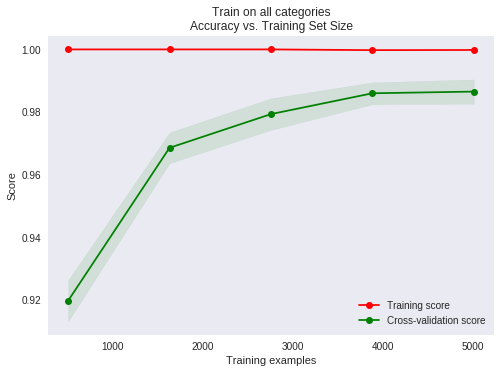

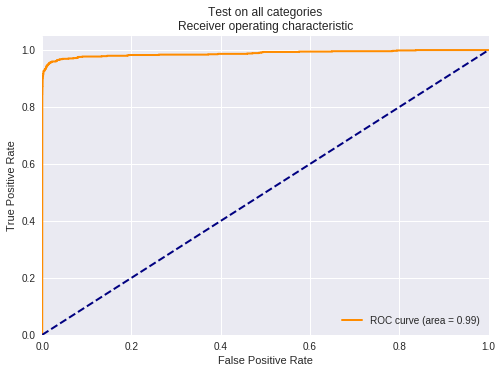

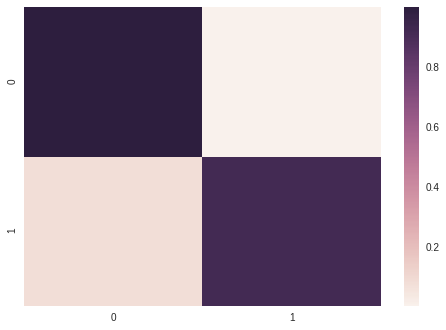

0.9882297528281381

In [16]:
# Print the results
#print_results(X_test, Y_test, preds_test, preds_test_scores, Y_test, f1_test, val_acc_test, vectorizer, clf)
# Print the results
print_results(X, Y, preds, preds_scores, test_gt, f1_folds, val_accuracy, vectorizer, clf)

In [17]:
# Model inspection
model_inspection(clf, vectorizer)

Number of non zero coefficients: 20312

Top-20 most predicive feats for each class
------
Class SPAM: ['take part' 'ringtone is waiting' 'box 113 bray' 'told dat'
 'team scoring starts' 'callcost 150ppm' '12 mths' 'over 18' 'light'
 'can bathe' 'on yer' '350 award if' 'to speak' 'cardiff is'
 'any time after' 'plaza' '150p min 18' 'once get' 'getstop on'
 'on 09056242159']

Class HAM: ['mobile from only' 'lor we' 'but pain' 'juz go' 've not' 'entered my'
 'sae box326 cw25wx' 'inches' 'home liao' 'com there' 'howz that'
 'settled in for' 'gt at' 'free bx420' 'got that persons' 'threw thm'
 'girl margaret hello' 'is rs lt' 'are entitled to' 'friends what you']

